#### PCA on the NC160 Data
We want to perform PCA on NC160 data. The data first needs to be scaled to have standard deviation of 1.

In [16]:
# reading the data from ISLP library
from ISLP import load_data


NCI60 = load_data('NCI60')

nci_data = NCI60['data']
nci_labs = NCI60['labels']

In [7]:
nci_data.shape

(64, 6830)

In [25]:
type(nci_data)

numpy.ndarray

In [26]:
type(nci_labs)

pandas.core.frame.DataFrame

In [28]:
nci_labs.value_counts()

label      
NSCLC          9
RENAL          9
MELANOMA       8
BREAST         7
COLON          7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7A-repro    1
MCF7D-repro    1
UNKNOWN        1
dtype: int64

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


scaler = StandardScaler()
nci_scaled = scaler.fit_transform(nci_data)

nci_pca = PCA()
nci_scores = nci_pca.fit_transform(nci_scaled)

### Find a good interpretion of the following plots
Below is the indication that cell lines of the same cancer type tend to have pretty similar gene expression levels
and thus observations belonging to a single cancer type tend to lie close to eachother in a lower dimensional space.

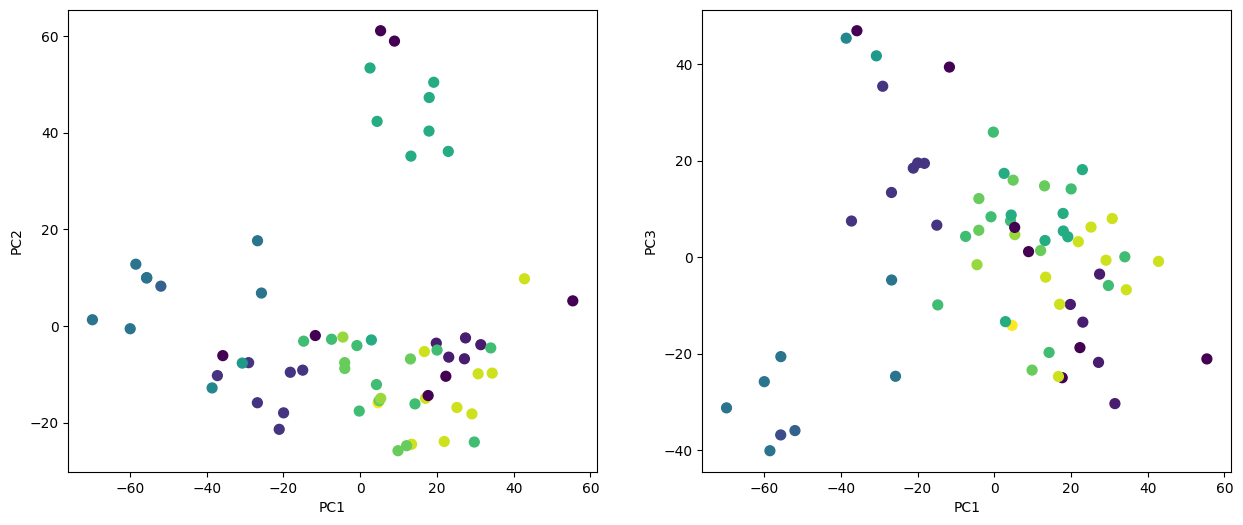

In [31]:
cancer_types = list(np.unique(nci_labs))
nci_groups = np.array ([ cancer_types.index(lab) for lab in nci_labs.values ])


fig , axes = plt.subplots (1, 2, figsize =(15 ,6))
ax = axes [0]
ax.scatter(nci_scores [:,0],
nci_scores [:,1],
c=nci_groups ,
marker='o',
s=50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax = axes [1]
ax.scatter(nci_scores [:,0],
nci_scores [:,2],
c=nci_groups ,
marker='o',
s=50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC3');

### What do the following plots show?
The following plot on the left shows percent variance explained(PVE) by the principal components.
The plot on the right show the cumulative.
Having a look at the following scree plot, around 40% of the variance is explained by seven principal components.
There is an *elbow* approximately after 7 principal components. This suggests that examining more than 7 PCs might not do a lot of help.

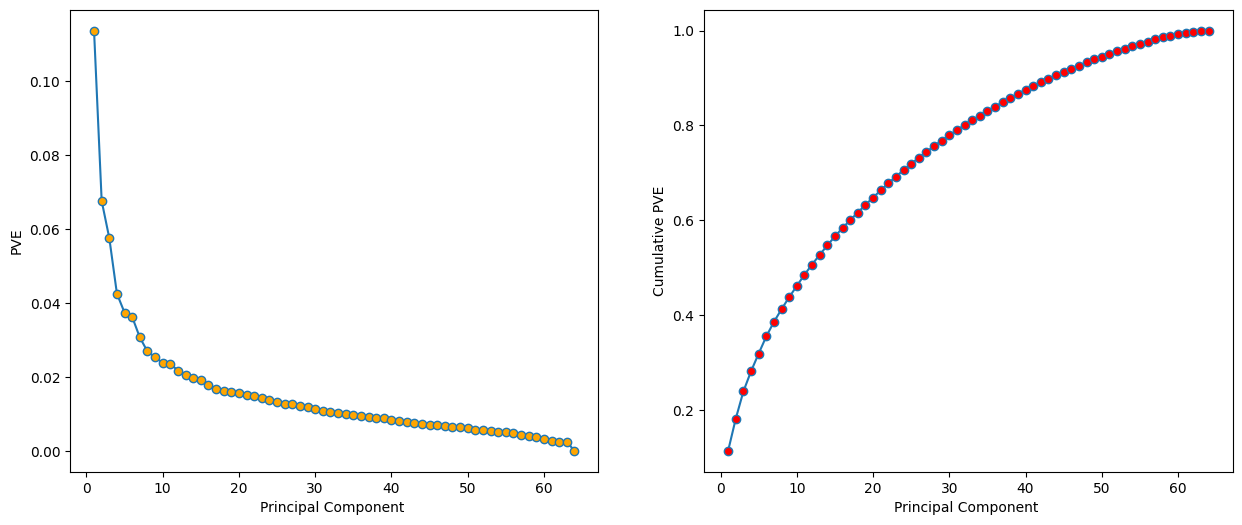

In [48]:
fig , axes = plt.subplots (1, 2, figsize =(15 ,6))
ax = axes [0]
ticks = np.arange(nci_pca.n_components_)+1
ax.plot(ticks ,
        nci_pca.explained_variance_ratio_ ,
        marker='o',
        markerfacecolor='orange')

ax.set_xlabel('Principal Component ');
ax.set_ylabel('PVE')

ax = axes [1]
ax.plot(ticks ,
        nci_pca. explained_variance_ratio_ .cumsum (),
        marker='o',
        markerfacecolor='red');
ax.set_xlabel('Principal Component ')
ax.set_ylabel('Cumulative PVE');

### Clustering the NCI160 Dataset
We are going to perform **hierarchical clustering** of the cell lines of NCI160 dataset. The main objective would be to find whether the observations cluster into distinct groups.
As the dissimilarity measure we have used Euclidean distance.

In [83]:
from sklearn.cluster import AgglomerativeClustering as HClust
from ISLP.cluster import compute_linkage
from scipy.cluster.hierarchy import dendrogram, cut_tree

def plot_nci(linkage, ax, cut=-np.inf):
    """
    Plot a dendrogram for the NCI60 data using hierarchical clustering.

    This function performs hierarchical clustering on the NCI60 data using the specified 
    linkage method, computes the linkage matrix, and plots a dendrogram on the given 
    matplotlib Axes object.

    Parameters:
    -----------
    linkage : str
        The linkage criterion to use for hierarchical clustering. This should be one of
        'ward', 'complete', 'average', or 'single'. The value is converted to lowercase 
        within the function.
    ax : matplotlib.axes.Axes
        The matplotlib Axes object on which to plot the dendrogram.
    cut : float, optional
        The threshold to color clusters in the dendrogram. Clusters formed below this 
        threshold are colored differently. The default is negative infinity, meaning no 
        color thresholding is applied.

    Returns:
    --------
    hc : HClust
        The fitted hierarchical clustering model.

    Notes:
    ------
    The function relies on a global variable `nci_scaled` which should contain the scaled 
    NCI60 data and `nci_labs` which should contain the labels for the NCI60 data points.
    
    Example:
    --------
    >>> fig, ax = plt.subplots()
    >>> hc = plot_nci('ward', ax)
    >>> plt.show()

    """
    cargs = {'above_threshold_color': 'black',
             'color_threshold': cut}
    hc = HClust(n_clusters=None,
                distance_threshold=0,
                linkage = linkage.lower()).fit(nci_scaled)
    
    linkage_ = compute_linkage(hc)
    
    dendrogram(linkage_,
               ax=ax,
               labels=np.asarray(nci_labs),
               leaf_font_size=8,
               **cargs)
    ax.set_title('%s Linkage' % linkage)
    return hc


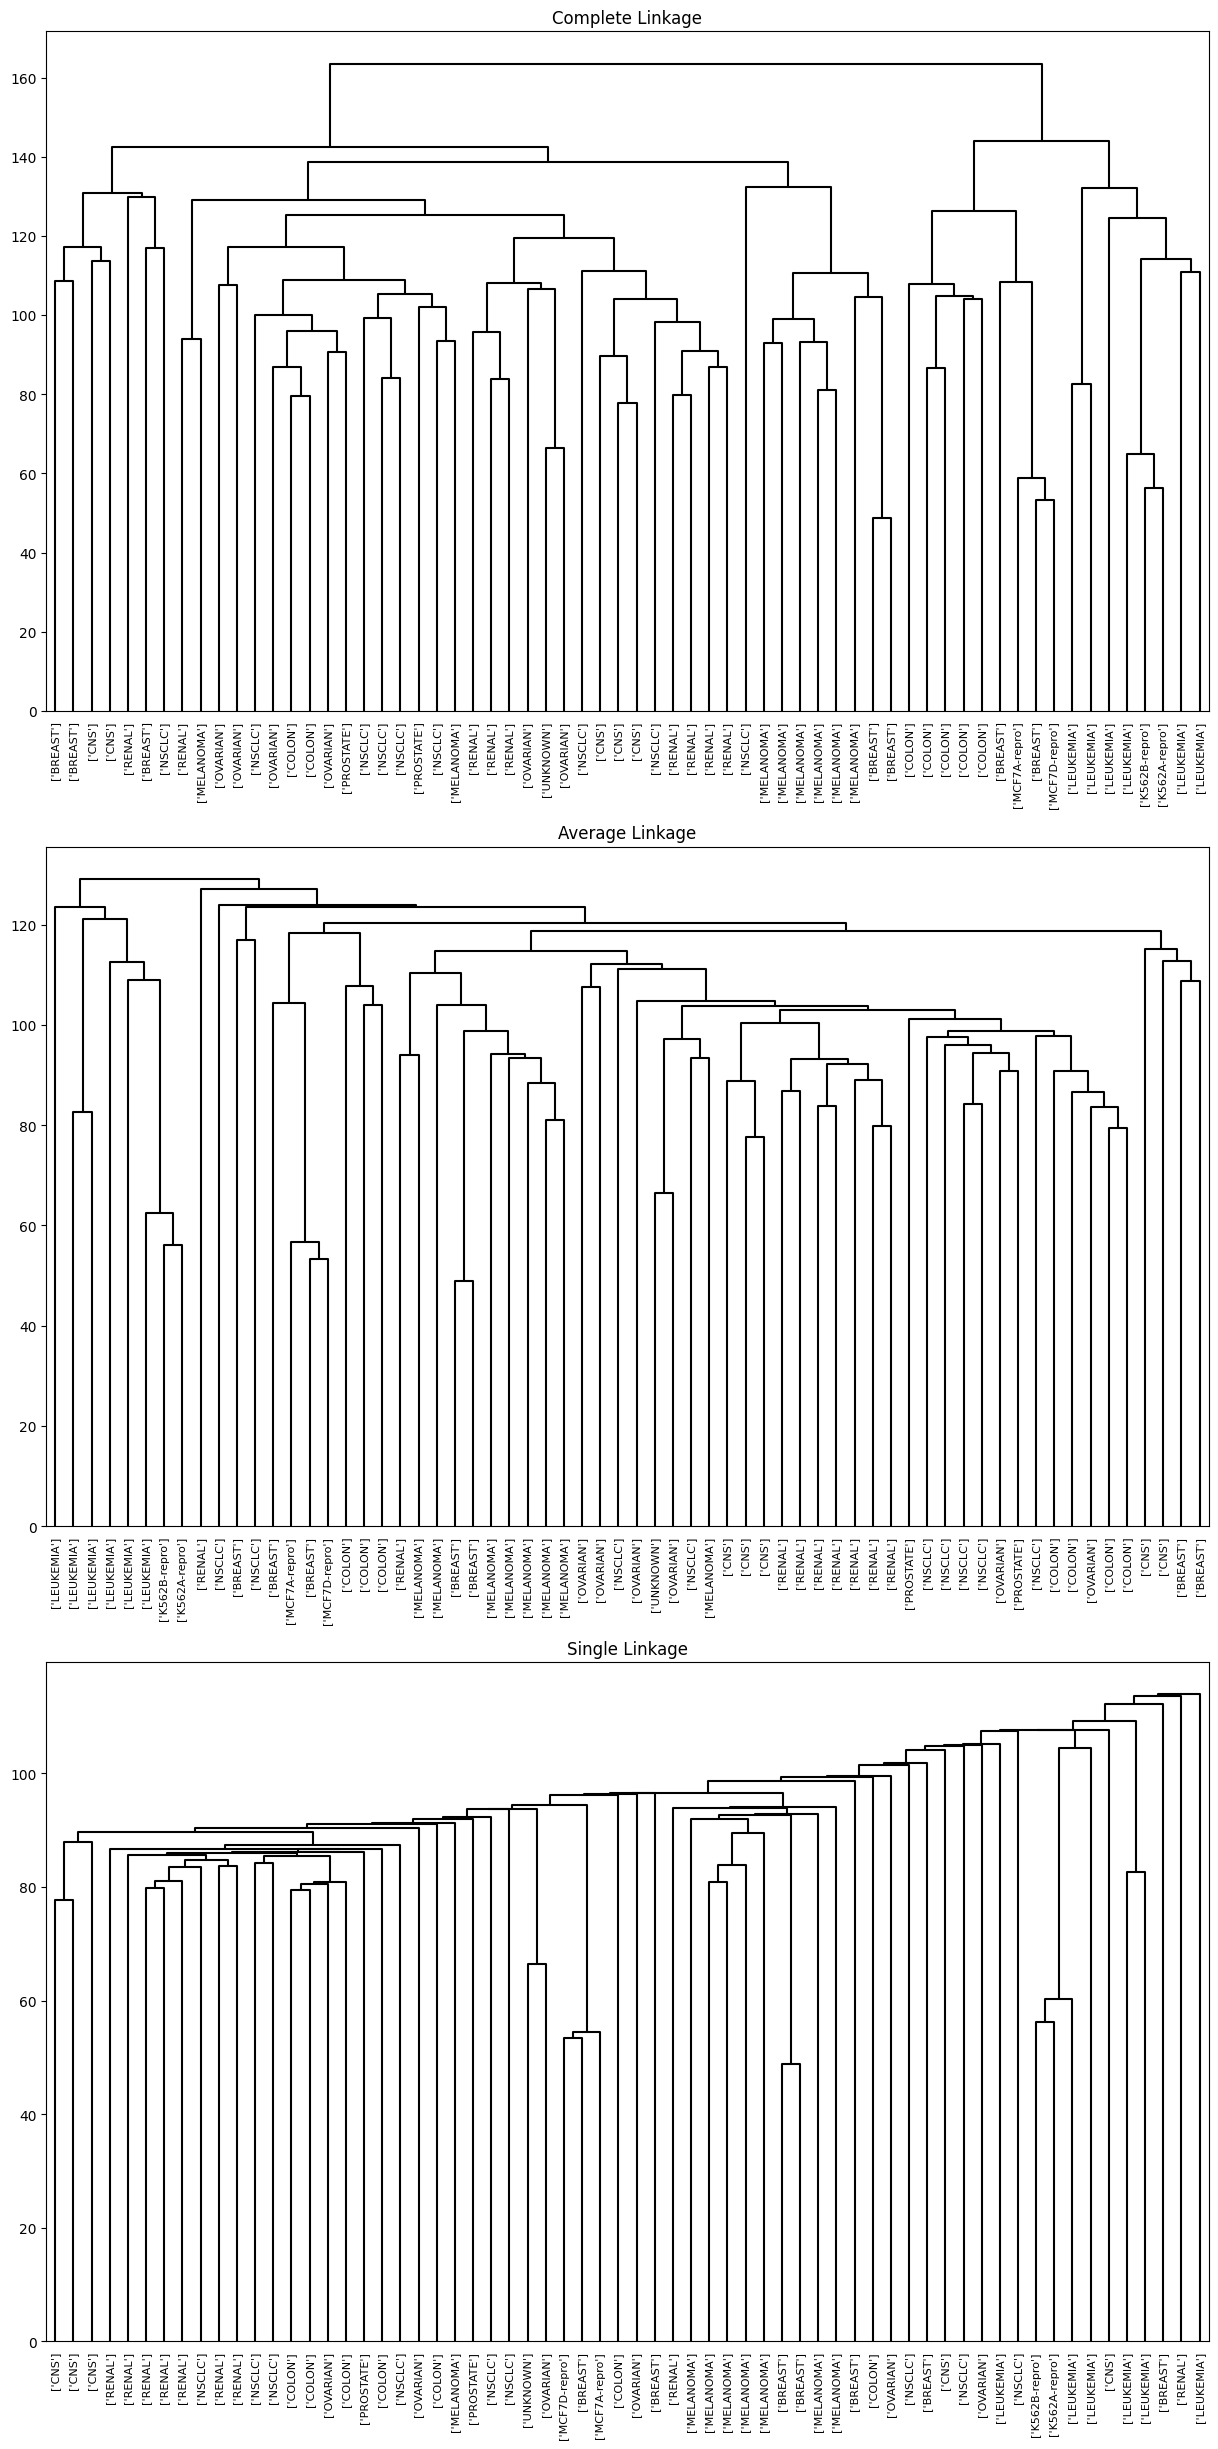

In [80]:
fig , axes = plt.subplots (3, 1, figsize =(15 ,30))
ax = axes [0]; hc_comp = plot_nci('Complete', ax)
ax = axes [1]; hc_avg = plot_nci('Average', ax)
ax = axes [2]; hc_sing = plot_nci('Single', ax)

fig.savefig(fname='dendogram')

In [75]:
# writing a function to save the plot
def save_fig(fig):
    fig.save_fig()

In [85]:
import pandas as pd

linkage_comp = compute_linkage (hc_comp)
comp_cut = cut_tree(linkage_comp , n_clusters =4).reshape (-1)
pd.crosstab(nci_labs['label'],
pd.Series(comp_cut.reshape (-1), name='Complete '))

Complete,0,1,2,3
label,,,,
BREAST,2,3,0,2
CNS,3,2,0,0
COLON,2,0,0,5
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


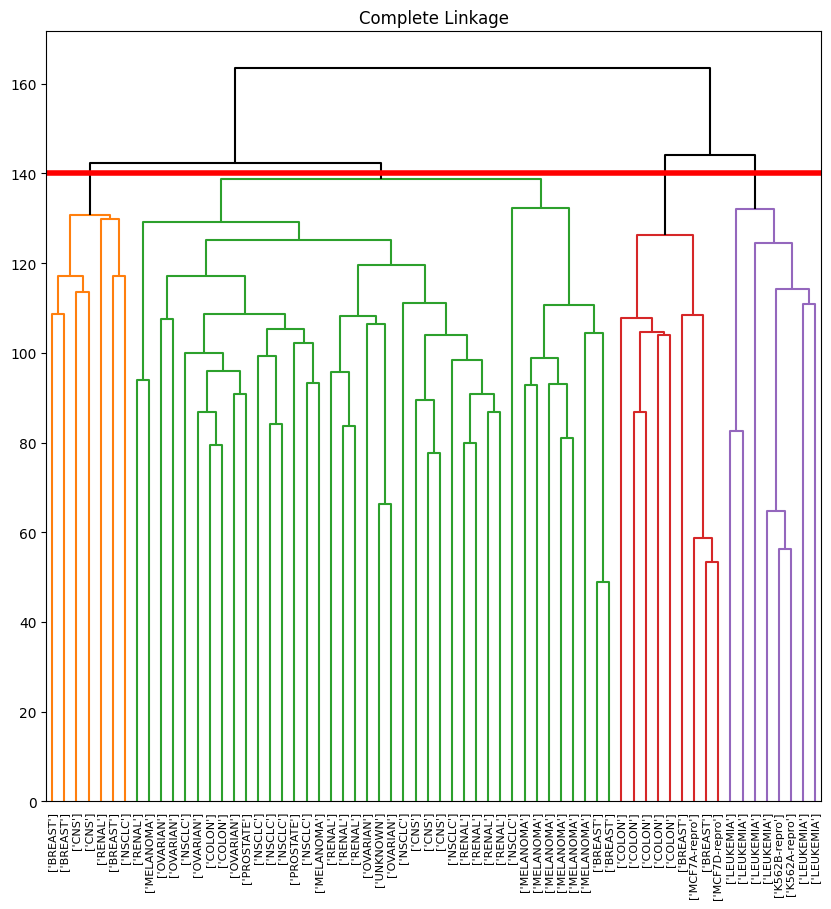

In [88]:
fig , ax = plt.subplots(figsize =(10 ,10))
plot_nci('Complete', ax , cut =140)
ax.axhline (140, c='r', linewidth =4);

# save the figure
fig.savefig(fname="cut_tree_dendo")